# Network Visualizations
Includes topological and temporal visualizations of the $pq$-network.

Documentation used: https://networkx.github.io/documentation/stable/tutorial.html  
https://networkx.github.io/documentation/stable/reference/drawing.html

In [1]:
import networkx as nx
import xlrd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

from pq_helper import get_dataframe

First, load in the data:

In [2]:
data_path = 'data/'
path = os.path.join(data_path, 'acm95a100a2018_anonymized_modified.xlsx')
(p_nodes, q_nodes, links, mod_p_nodes) = get_dataframe(path)

In [4]:
p_nodes

,ID,Role,Class,Option,Section,DaysOnline,Views,Contributions,Questions,Notes,Answers,N-Score,Grade,Status,In-Degree,Out-Degree,Seniority
0,P1,Student,U2,ME,5.0,48,60,0,0,0,0,0.531170,B+,0,0,0,U
1,P2,Student,U2,ACM,5.0,150,219,14,0,0,13,0.918357,A+,1,1,5,U
2,P3,Student,U2,ACM,7.0,245,215,9,1,0,4,0.864791,A+,1,4,4,U
3,P4,Student,U3,CS,1.0,107,215,3,0,0,2,0.928847,A+,1,0,3,U
4,P5,Student,U2,ME,3.0,53,216,38,10,0,15,0.944688,A+,1,20,9,U
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,P192,TA,NaN,NaN,8.0,59,88,1,0,0,0,NaN,NaN,1,0,1,N
192,P193,TA,NaN,NaN,9.0,78,34,0,0,0,0,NaN,NaN,1,0,1,N
193,P194,TA,NaN,NaN,10.0,36,53,3,0,2,1,NaN,NaN,0,0,0,N
194,P195,Head TA,NaN,NaN,NaN,74,237,228,0,7,153,NaN,NaN,1,0,125,N


Our first network visualization will be a topological visualization that displays all links and nodes on a plane.

We will extract the list of p-nodes with Status $=1$ in the order in which they participated:

In [4]:
status1 = [] # list of status 1 p-nodes
for item in links['Start']:
    if (item[0] == 'P') and (item not in status1):
        status1.append(item)
for item in links['End']:
    if (item[0] == 'P') and (item not in status1):
        status1.append(item)  

We then read in the adjacency matrix constructed from the network links and create a directed bipartite graph from it:

In [9]:
# read in adjacency matrix (which accounts for status 1 nodes only)
book = pd.ExcelFile(os.path.join(data_path, 'adjacency_matrix_with_headers.xlsx'))
df = book.parse()    
    
# create directed graph from adjacency matrix
G = nx.from_numpy_matrix(df.values.transpose(), create_using=nx.DiGraph())

Next, we will relabel the p-nodes with Status $=1$ and the q-nodes so that their numbering starts from 1. This will faciliate our later plots.

In [10]:
new_labels = {}
    
for i in range(96): # relabel p-nodes
    new_labels[i] = status1[i]
for j in range(96, 337): # label q-nodes 
    new_labels[j] = 'Q' + str(j - 95)
        
nx.relabel_nodes(G, new_labels, copy=False)

Now we can set the attributes for our graph:

In [12]:
# set different node shapes for p-nodes and q-nodes
node_shape = {}
for node in G.nodes():
    if node[0] == 'P':
        node_shape[node] = 'o'
    else:
        node_shape[node] = 's'
    
nx.set_node_attributes(G, node_shape, 'shape')   
   
# set different edge colors for links from p- to q-nodes and links from q- to p-nodes
edge_color = {}
for edge in G.edges():
    if edge[0][0] == 'P':
        edge_color[edge] = 'blue'
    else:
        edge_color[edge] = 'red'
    
nx.set_edge_attributes(G, edge_color, 'color') 
    
# adjust k to change how closely nodes are distributed in image
nodePos = nx.layout.spring_layout(G, k=0.3, iterations=20)
nodeShapes = ['o', 's']
edgeColors = ['blue', 'red']

Finally, we draw the graph:

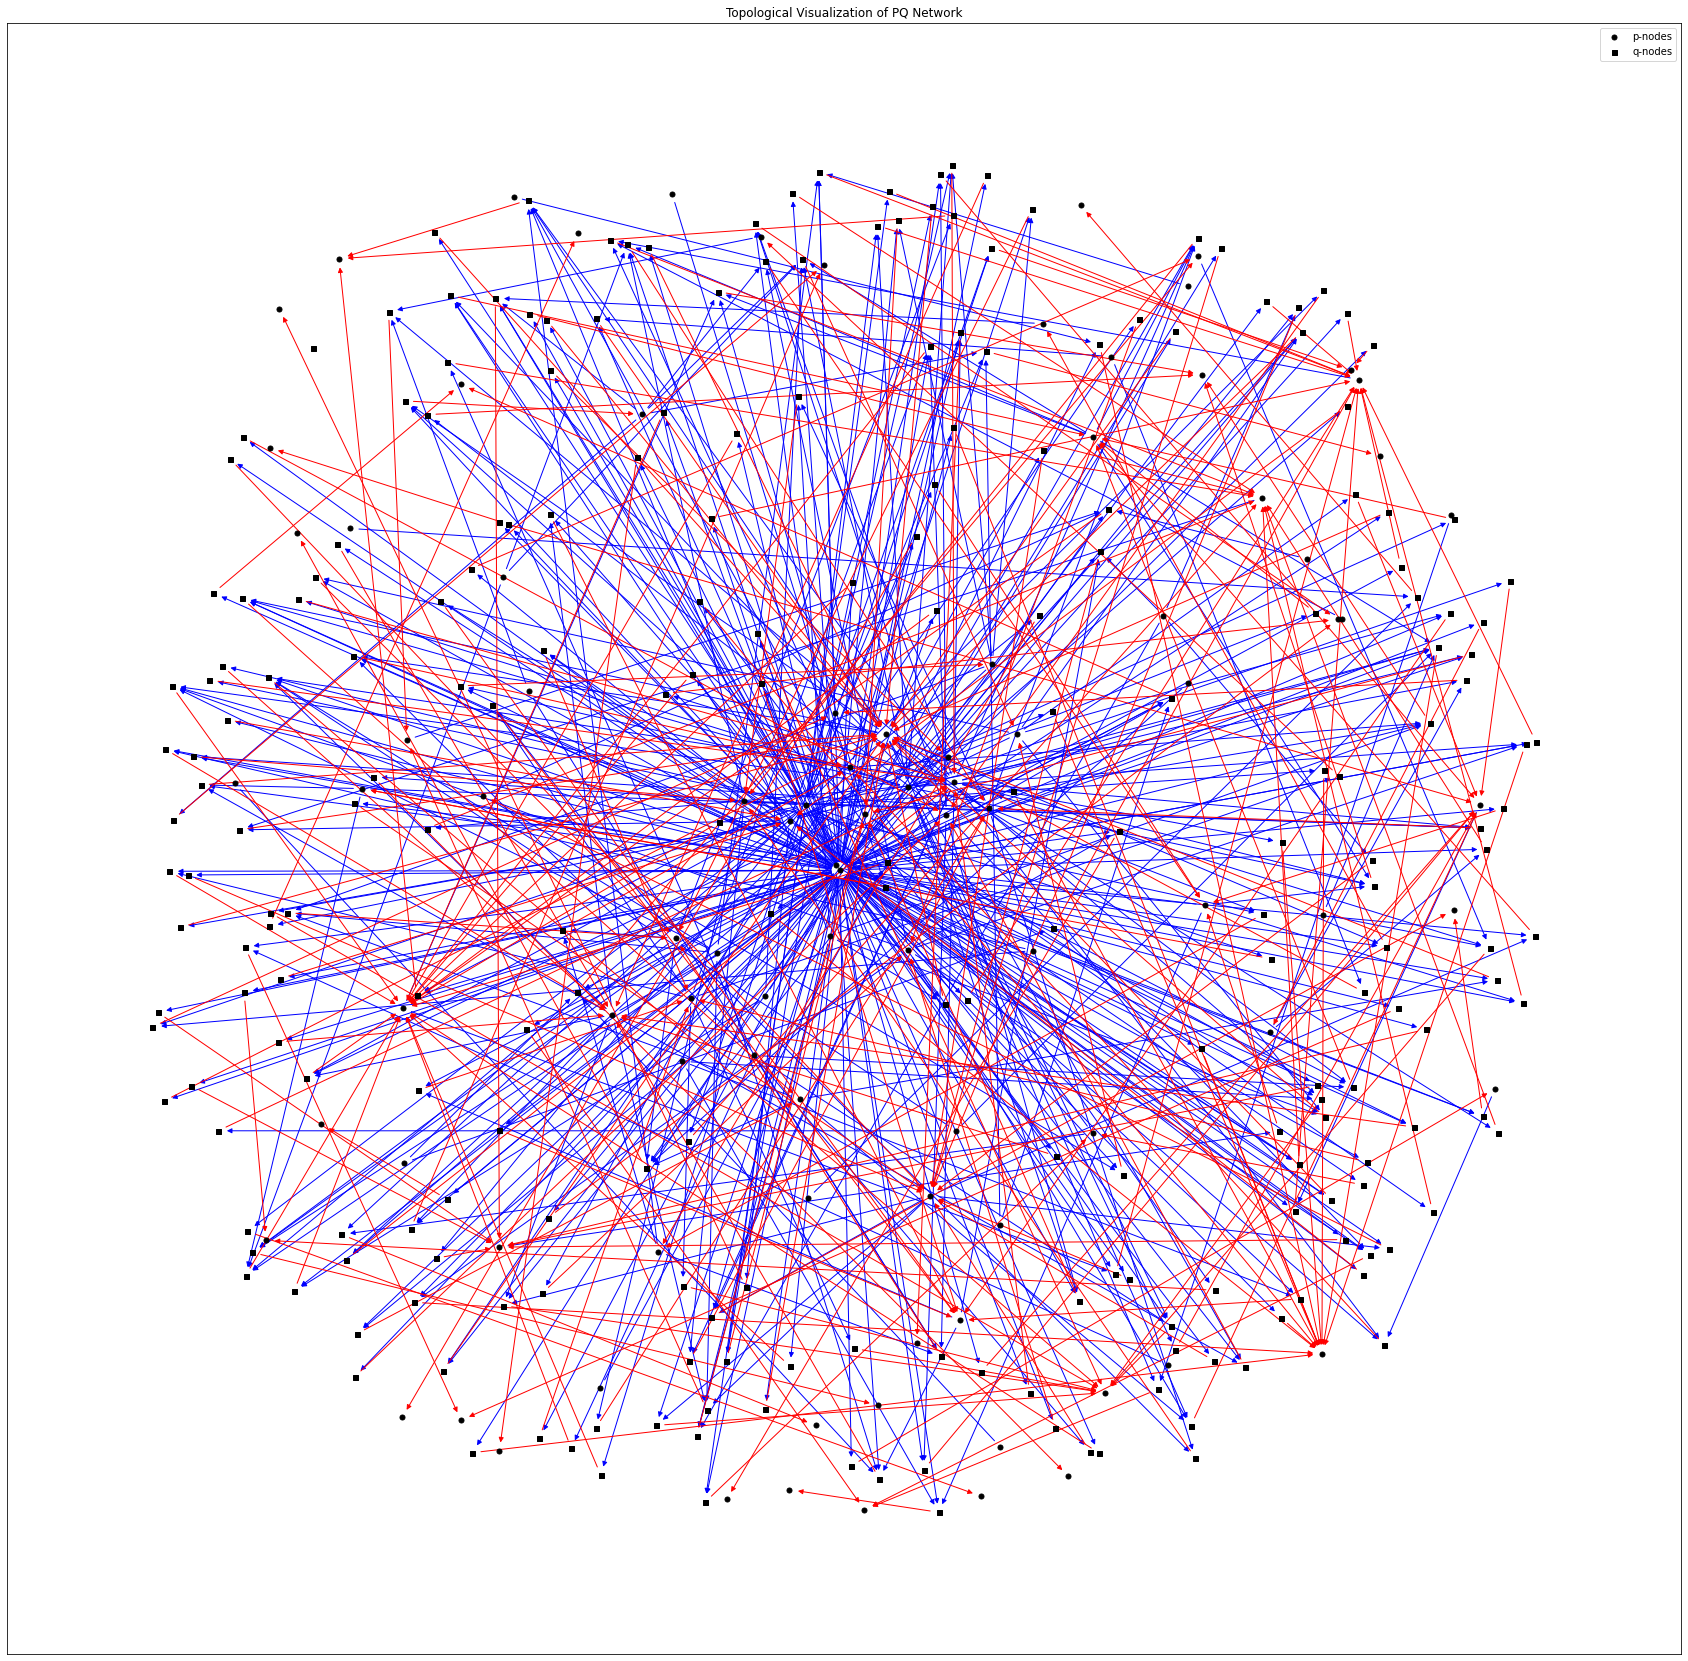

In [15]:
plt.figure(figsize=(30,30))

# draw nodes
for shape in nodeShapes:
    if shape == 'o':
        node_label = 'p-nodes'
    else:
        node_label = 'q-nodes'
    nx.draw_networkx_nodes(G, nodePos, node_shape=shape, 
                            nodelist=[sNode[0] for sNode in filter(lambda x: x[1]['shape']==shape, G.nodes(data = True))], 
                            node_size=25, node_color='black', label=node_label)
    
# draw edges
for color in edgeColors:
    nx.draw_networkx_edges(G, nodePos, edge_color=color, 
                            edgelist=[sEdge for sEdge in filter(lambda x: x[2]['color']==color, G.edges(data = True))])    
    
plt.title('Topological Visualization of PQ Network')
plt.legend()

We can adjust the density of the nodes by changing $k$ above, but it is still difficult to identify useful patterns due to the large number of nodes and connections present. The network is almost completely connected; there is a lone q-node that has no links in the spreadsheet and one other component comprised of 4 nodes. The rest of the graph is connected.

We will next look at a temporal visualization of the network. We have the order (network time) in which nodes and links appeared, and we use this information to create a network where nodes are place along a time line. 

General approach and notes:

We add a new q-node and a new p-node at the network time that a new question is asked, along with the corresponding link between them.

Every time a question is answered, add a new p-node for the person answering and have a link pointing back to the time the question was originally asked (no new q-node). Links from p-nodes to q-nodes will help us visualize how long it took for questions to be answered.

q-nodes will be unique on the timeline but p-nodes may not be (the reason being that if a p-node is unique, then if the person answers any questions following its first appearance in the network, we will lose information about when the question was answered).

Number the p-nodes according to the number of times they have participated (i.e. P1 1, P1 2, etc.)

Colors are added to distinguish between links from q-nodes to p-nodes (red, pointing up) and links from p-nodes to q-nodes (blue, pointing down).

In [104]:
df = pd.crosstab(p_nodes['Grade'], mod_p_nodes['Status'])
df['1 %'] = (100 * df[1] / (df[0] + df[1])).round(1)
df['1 %'] = df['1 %'].apply(lambda x: str(x) + '%')
df      

Status,0,1,1 %
Grade,,,
A,31,33,51.6%
A+,16,37,69.8%
A-,17,13,43.3%
B,6,1,14.3%
B+,13,2,13.3%
B-,5,2,28.6%
C,2,1,33.3%
C+,1,1,50.0%
C-,2,0,0.0%


<Figure size 432x288 with 0 Axes>

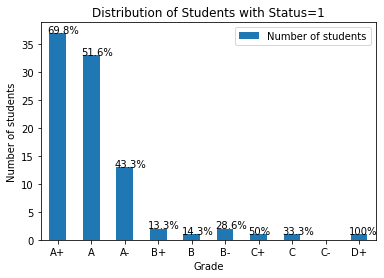

In [105]:
grade_statuses = [37, 33, 13, 2, 1, 2, 1, 1, 0, 1] 
percentages = ['69.8%', '51.6%', '43.3%', '13.3%', '14.3%', '28.6%', '50%', 
               '33.3%', '', '100%']
    
annotated_bar_chart(grades, grade_statuses, percentages, -0.1, 
                    'Grade', 'Number of students', 
                    'Distribution of Students with Status=1')     

We observe that the percentage of participating p-nodes is higher than average for students who received an A+, and about average for those who received an A. Participation is slightly below average for those who received A- grades, and much lower than average for those who received grades in the B range. For students in the C or D range, the overall number of students is small, so the percentages do not give much insight. 

We can also plot the same graph without $\pm$ grades:

In [106]:
df = pd.crosstab(mod_p_nodes['Grade'], mod_p_nodes['Status'])
df['1 %'] = (100 * df[1] / (df[0] + df[1])).round(1)
df['1 %'] = df['1 %'].apply(lambda x: str(x) + '%')
df 

Status,0,1,1 %
Grade,,,
A,64,83,56.5%
B,24,5,17.2%
C,5,2,28.6%
D,0,1,100.0%


<Figure size 432x288 with 0 Axes>

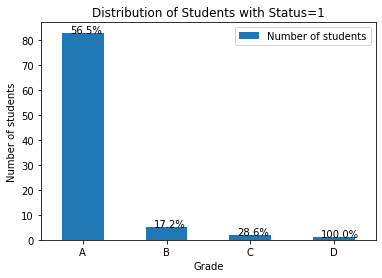

In [107]:
annotated_bar_chart(combined_grades, df[1], df['1 %'], 1/5, 
         'Grade', 'Number of students', 
        'Distribution of Students with Status=1')  

This confirms what we observed above: the participation rate is much higher for students who scored in the A range compared to those who scored in the B range. This suggests that more participation in the collaboration network helped students perform better in the course. We speculate that this could be in part because those who asked more questions ended up learning the material better, or because those who knew the material better ended up answering more questions. 

In summary, about $50\%$ of all students participated in the network. Some options, like the ACM option, participated more than others. In particular, students who received A grades participated more than students who received B grades. 

### Attributions

Notebook created by Amanda Li. 

Modified from `visualizations_p_nodes_status.py` by Amanda Li.